In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
import ast
import numpy as np
from statistics import mean 

In [2]:
movies_2015_2024 = pd.read_csv('../data/movies_2015_2024.csv')
movies_2015_2024.head(2)

,Title,Year,Genre,Vote_Average,Vote_Count,Budget,Revenue,TMDB_ID
0,Avengers: Age of Ultron,2015,"['Action', 'Adventure', 'Science Fiction']",7.271,23855,365000000,1405403694,99861
1,Mad Max: Fury Road,2015,"['Action', 'Adventure', 'Science Fiction']",7.627,23511,150000000,378858340,76341


In [3]:
movies_2015_2024['Profit'] = (movies_2015_2024["Revenue"] - movies_2015_2024["Budget"])
movies_2015_2024.head(2)

,Title,Year,Genre,Vote_Average,Vote_Count,Budget,Revenue,TMDB_ID,Profit
0,Avengers: Age of Ultron,2015,"['Action', 'Adventure', 'Science Fiction']",7.271,23855,365000000,1405403694,99861,1040403694
1,Mad Max: Fury Road,2015,"['Action', 'Adventure', 'Science Fiction']",7.627,23511,150000000,378858340,76341,228858340


In [4]:
# Converting financial data to 2024 dollars
# Store CPI values
cpi_data = pd.read_csv('../data/CPI_data.csv').set_index('Year')
budget_2024 = []
for year,budget in zip(movies_2015_2024['Year'], movies_2015_2024['Budget']):
    budget_adjusted = budget*(cpi_data.loc[2024,'CPI'] / cpi_data.loc[year,'CPI'])
    budget_2024.append(budget_adjusted)
# Reassign adjusted budget numbers to the Budget column
movies_2015_2024['Budget'] = budget_2024
revenue_2024 = []
for year,revenue in zip(movies_2015_2024['Year'], movies_2015_2024['Revenue']):
    revenue_adjusted = revenue*(cpi_data.loc[2024,'CPI'] / cpi_data.loc[year,'CPI'])
    revenue_2024.append(revenue_adjusted)
# Reassign adjusted budget numbers to the Revenue column
movies_2015_2024['Revenue'] = revenue_2024
# Dropping zero values from budget and revenue
movies_2015_2024 = movies_2015_2024[~((movies_2015_2024['Revenue'].round() == 0.0) | (movies_2015_2024['Budget'].round() == 0.0))]
movies_2015_2024.head(2)

,Title,Year,Genre,Vote_Average,Vote_Count,Budget,Revenue,TMDB_ID,Profit
0,Avengers: Age of Ultron,2015,"['Action', 'Adventure', 'Science Fiction']",7.271,23855,4.830729e+08,1.860034e+09,99861,1040403694
1,Mad Max: Fury Road,2015,"['Action', 'Adventure', 'Science Fiction']",7.627,23511,1.985231e+08,5.014142e+08,76341,228858340


In [5]:
movies_2015_2024['Budget'].nsmallest()

377    4.372286e+04
873    1.029494e+05
755    2.679683e+05
732    1.071873e+06
752    1.071873e+06
Name: Budget, dtype: float64

#### Exploratory Question: How do movie ratings (vote average) relate to box-office performance? #4

In [7]:
movies_2015_2024['Genre'] = movies_2015_2024['Genre'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else x)
movies_exploded = movies_2015_2024.explode('Genre', ignore_index = False)
movies_exploded.head(2)

,Title,Year,Genre,Vote_Average,Vote_Count,Budget,Revenue,TMDB_ID,Profit
0,Avengers: Age of Ultron,2015,Action,7.271,23855,4.830729e+08,1.860034e+09,99861,1040403694
0,Avengers: Age of Ultron,2015,Adventure,7.271,23855,4.830729e+08,1.860034e+09,99861,1040403694


In [8]:
movies_exploded['Budget'].nsmallest(50)

377     4.372286e+04
377     4.372286e+04
873     1.029494e+05
873     1.029494e+05
755     2.679683e+05
755     2.679683e+05
732     1.071873e+06
732     1.071873e+06
752     1.071873e+06
752     1.071873e+06
354     1.249224e+06
354     1.249224e+06
354     1.249224e+06
372     1.249224e+06
372     1.249224e+06
372     1.249224e+06
278     1.279736e+06
278     1.279736e+06
424     1.476359e+06
424     1.476359e+06
424     1.476359e+06
996     1.480000e+06
996     1.480000e+06
1002    1.504948e+06
942     2.000000e+06
946     2.000000e+06
946     2.000000e+06
538     2.060466e+06
538     2.060466e+06
538     2.060466e+06
680     2.315304e+06
87      2.382277e+06
87      2.382277e+06
87      2.382277e+06
284     2.559473e+06
284     2.559473e+06
284     2.559473e+06
285     2.559473e+06
83      2.646975e+06
83      2.646975e+06
83      2.646975e+06
975     3.000000e+06
975     3.000000e+06
35      3.044021e+06
35      3.044021e+06
725     3.215619e+06
726     3.215619e+06
795     3.215

In [9]:
movies_exploded['log_rev'] = np.log(movies_exploded['Revenue']+1)
movies_exploded.head(2)

,Title,Year,Genre,Vote_Average,Vote_Count,Budget,Revenue,TMDB_ID,Profit,log_rev
0,Avengers: Age of Ultron,2015,Action,7.271,23855,4.830729e+08,1.860034e+09,99861,1040403694,21.343861
0,Avengers: Age of Ultron,2015,Adventure,7.271,23855,4.830729e+08,1.860034e+09,99861,1040403694,21.343861


In [10]:
movies_exploded['rev_minus_budget'] = movies_exploded['Revenue'].sub(movies_exploded['Budget'], axis=0)
movies_exploded.head(2)

,Title,Year,Genre,Vote_Average,Vote_Count,Budget,Revenue,TMDB_ID,Profit,log_rev,rev_minus_budget
0,Avengers: Age of Ultron,2015,Action,7.271,23855,4.830729e+08,1.860034e+09,99861,1040403694,21.343861,1.376961e+09
0,Avengers: Age of Ultron,2015,Adventure,7.271,23855,4.830729e+08,1.860034e+09,99861,1040403694,21.343861,1.376961e+09


#### The R-squared is in line with what is seen in these plots in that there is still a significant amount of variability that hasn't been explained with just Vote Average and Revenue. We have a low r-squared value as it is looking at how much variability in Vote Average vs Revenue is explained by the model. 

In [12]:
lm_vtavg_rev_exploded = smf.ols('Vote_Average ~ Revenue', data = movies_exploded).fit()
lm_vtavg_rev_exploded.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Vote_Average   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     86.88
Date:                Sat, 22 Nov 2025   Prob (F-statistic):           2.62e-20
Time:                        19:30:40   Log-Likelihood:                -2177.2
No. Observations:                2288   AIC:                             4358.
Df Residuals:                    2286   BIC:                             4370.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.7996      0.016    415.192      0.000       6.767       6.832
Revenue     2.863e-10   3.07e-11      9.321      0.000    2.26e-10    3.47e-10
==============================================================================
Omnibus:                        7.197   Durbin-Watson:                   0.665
Prob(Omnibus):                  0.027   Jarque-Bera (JB):                7.208
Skew:                          -0.137   Prob(JB):                       0.0272
Kurtosis:                       3.002   Cond. No.                     6.66e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.66e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [13]:
lm_vtavg_rev_exploded = smf.ols('Vote_Average ~ rev_minus_budget', data = movies_exploded).fit()
lm_vtavg_rev_exploded.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Vote_Average   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     115.6
Date:                Sat, 22 Nov 2025   Prob (F-statistic):           2.44e-26
Time:                        19:30:40   Log-Likelihood:                -2163.4
No. Observations:                2288   AIC:                             4331.
Df Residuals:                    2286   BIC:                             4342.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            6.8067      0.015    447.443      0.000       6.777       6.836
rev_minus_budget  3.753e-10   3.49e-11     10.752      0.000    3.07e-10    4.44e-10
==============================================================================
Omnibus:                        6.390   Durbin-Watson:                   0.665
Prob(Omnibus):                  0.041   Jarque-Bera (JB):                6.410
Skew:                          -0.130   Prob(JB):                       0.0406
Kurtosis:                       2.991   Cond. No.                     5.09e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.09e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [14]:
lm_log_vtavg_rev_exploded = smf.ols('Vote_Average ~ I(np.log(Revenue+1))', data=movies_exploded).fit()
lm_log_vtavg_rev_exploded.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Vote_Average   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     23.06
Date:                Sat, 22 Nov 2025   Prob (F-statistic):           1.67e-06
Time:                        19:30:40   Log-Likelihood:                -2208.3
No. Observations:                2288   AIC:                             4421.
Df Residuals:                    2286   BIC:                             4432.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  6.1986      0.145     42.806      0.000       5.915       6.483
I(np.log(Revenue + 1))     0.0371      0.008      4.802      0.000       0.022       0.052
==============================================================================
Omnibus:                       10.803   Durbin-Watson:                   0.637
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               10.863
Skew:                          -0.169   Prob(JB):                      0.00438
Kurtosis:                       3.009   Cond. No.                         205.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

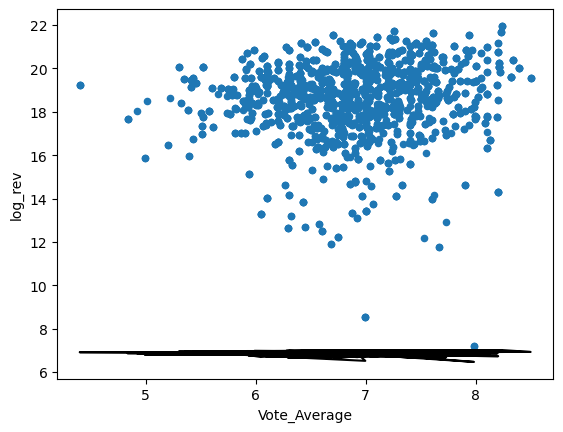

In [15]:
movies_exploded.plot(x = 'Vote_Average', y = 'log_rev', kind = 'scatter')
plt.plot(movies_exploded['Vote_Average'], lm_log_vtavg_rev_exploded.fittedvalues, color = 'black');

In [16]:
movies_exploded['Budget'].nsmallest(100)

377    4.372286e+04
377    4.372286e+04
873    1.029494e+05
873    1.029494e+05
755    2.679683e+05
           ...     
132    5.227998e+06
132    5.227998e+06
132    5.227998e+06
133    5.227998e+06
167    5.227998e+06
Name: Budget, Length: 100, dtype: float64

In [17]:
#movies_exploded_nolow = movies_exploded[movies_exploded.Budget > 0]
#movies_exploded_nolow['Budget'].nsmallest(25)
#df = df[df.line_race != 0]
#movies_exploded['Budget'].nsmallest(2)

In [58]:
#lm_vtavg_rev_exploded = smf.ols('Revenue ~ Vote_Average', data = movies_exploded).fit()
#lm_vtavg_rev_exploded.summary()

In [60]:
#lm_vtavg_rev_exploded = smf.ols('np.log(Revenue) ~ Vote_Average', data = movies_exploded).fit()
#lm_vtavg_rev_exploded.summary()

In [62]:
movies_2015_2024.nsmallest(3, "Profit")

,Title,Year,Genre,Vote_Average,Vote_Count,Budget,Revenue,TMDB_ID,Profit,Fitted_Values
727,The Gray Man,2022,"[Action, Thriller]",6.923,3989,2.143746e+08,4.866550e+05,725201,-199545977,19.535613
631,The Tomorrow War,2021,"[Action, Science Fiction, Adventure]",7.490,3871,2.315304e+08,1.667019e+07,588228,-185600000,19.639607
848,The Killer,2023,"[Crime, Thriller]",6.579,2560,1.801615e+08,3.727933e+05,800158,-174637887,19.472519


In [78]:
lm_vtavg_profit_20152024 = smf.ols('np.log(Profit) ~ Vote_Average', data = movies_2015_2024).fit()
lm_vtavg_profit_20152024.summary()

C:\Users\cat\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         np.log(Profit)   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     16.19
Date:                Sat, 22 Nov 2025   Prob (F-statistic):           6.39e-05
Time:                        19:32:42   Log-Likelihood:                -1215.8
No. Observations:                 665   AIC:                             2436.
Df Residuals:                     663   BIC:                             2445.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       15.7413      0.630     25.000      0.000      14.505      16.978
Vote_Average     0.3650      0.091      4.024      0.000       0.187       0.543
==============================================================================
Omnibus:                       69.888   Durbin-Watson:                   2.071
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              102.259
Skew:                          -0.749   Prob(JB):                     6.23e-23
Kurtosis:                       4.202   Cond. No.                         76.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [66]:
lm_vtavg_profit_20152024 = smf.ols('np.log1p(Profit+200000000) ~ Vote_Average', data = movies_2015_2024).fit()
lm_vtavg_profit_20152024.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     np.log1p(Profit + 200000000)   R-squared:                       0.036
Model:                                      OLS   Adj. R-squared:                  0.035
Method:                           Least Squares   F-statistic:                     30.33
Date:                          Sat, 22 Nov 2025   Prob (F-statistic):           4.90e-08
Time:                                  19:32:20   Log-Likelihood:                -736.34
No. Observations:                           805   AIC:                             1477.
Df Residuals:                               803   BIC:                             1486.
Df Model:                                     1                                         
Covariance Type:                      nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       18.2658      0.230     79.350      0.000      17.814      18.718
Vote_Average     0.1834      0.033      5.507      0.000       0.118       0.249
==============================================================================
Omnibus:                      334.113   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10860.395
Skew:                          -1.222   Prob(JB):                         0.00
Kurtosis:                      20.827   Cond. No.                         76.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [68]:
#lm_vtavg_profit_20152024 = smf.ols('Profit ~ Vote_Average', data = movies_2015_2024).fit()
#lm_vtavg_profit_20152024.summary()

In [70]:
#I(np.log1p(rev_minue_budget)

In [80]:
movies_2015_2024['Fitted_Values'] =lm_vtavg_profit_20152024.fittedvalues
movies_2015_2024 = movies_2015_2024.sort_values("Vote_Average")
movies_2015_2024

,Title,Year,Genre,Vote_Average,Vote_Count,Budget,Revenue,TMDB_ID,Profit,Fitted_Values
38,Fantastic Four,2015,"[Action, Adventure, Science Fiction]",4.400,6264,1.588185e+08,2.223162e+08,166424,47977596,17.347136
899,Asterix & Obelix: The Middle Kingdom,2023,"[Family, Comedy, Adventure]",4.837,1119,7.412360e+07,4.786910e+07,643215,-25502322,NaN
98,The Boy Next Door,2015,[Thriller],4.919,2089,5.293949e+06,6.938496e+07,241251,48425855,17.536553
873,Winnie the Pooh: Blood and Honey,2023,"[Horror, Thriller]",4.993,1512,1.029494e+05,7.944654e+06,980078,7617044,17.563560
293,Rings,2017,[Horror],5.010,2560,3.199341e+07,1.063216e+08,14564,58080890,17.569765
...,...,...,...,...,...,...,...,...,...,...
401,Avengers: Endgame,2019,"[Adventure, Science Fiction, Action]",8.237,26930,4.368090e+08,3.434888e+09,299534,2443439100,18.747509
903,The Wild Robot,2024,"[Animation, Science Fiction, Family, Adventure...",8.319,5494,7.800000e+07,3.319821e+08,1184918,253982078,18.777436
803,Spider-Man: Across the Spider-Verse,2023,"[Animation, Action, Adventure, Science Fiction]",8.338,8027,1.029494e+08,7.112755e+08,569094,590897910,18.784370
305,Spider-Man: Into the Spider-Verse,2018,"[Animation, Action, Adventure, Science Fiction]",8.395,16595,1.124302e+08,4.916978e+08,324857,303602435,18.805173


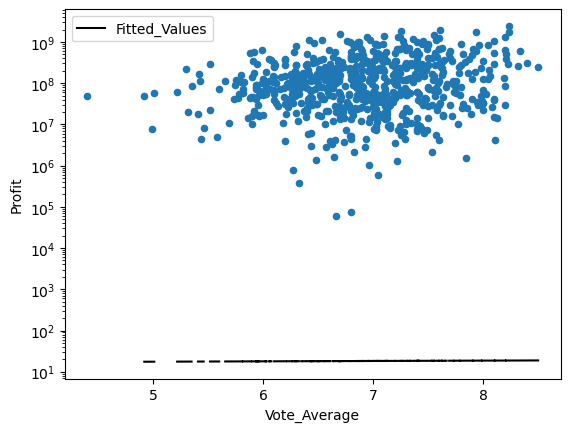

In [82]:
ax = movies_2015_2024.plot(
    x='Vote_Average',
    y='Profit',
    kind='scatter', 
    logy=True
)

movies_2015_2024.plot(
    ax=ax, x="Vote_Average", y="Fitted_Values", color='black'
);

#plt.annotate(text = 'P>|t|=0.000\nR-squared = 0.027', xy = (2e9, 6), fontsize = 12, xytext = (1.5e9, 6))
#plt.annotate(text = 'R-squared = 0.027', xy = (2e9, 6), fontsize = 12, xytext = (2e9, 6))
#, #arrowprops=dict(facecolor='black', shrink=0.1));